In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")
muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

C:\Users\perezandrea.UNICAN\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Todos los paquetes necesarios han sido importados


In [ ]:
data_sonda_2023_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Python = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoPython.csv', index_col=[0,1,2,3,4,5,6,7])
data_nanobase = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\\nanobasepreprocesado.csv', index_col=[0])

data_sonda_2024_Matlab_muestras = data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist()
data_sonda_2024_Python_muestras = data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist()
data_sonda_2023_Matlab_muestras = data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist()
data_nanobase_muestras = data_nanobase.index.get_level_values("Muestra").unique().tolist()

print("Las muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab_muestras)
print("Las muestras de 2024 en Python son: ", data_sonda_2024_Python_muestras)
print("Las muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab_muestras)
print("Las muestras de Nanobase son: ", data_nanobase_muestras)

print('Las dimensiones de los datasets son: ')
print('Sonda 2023 Matlab: ', data_sonda_2023_Matlab.shape)
print('Sonda 2024 Matlab: ', data_sonda_2024_Matlab.shape)
print('Sonda 2024 Python: ', data_sonda_2024_Python.shape)
print('Nanobase: ', data_nanobase.shape)


Las muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT921.1']
Las muestras de 2024 en Python son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT921.1']
Las muestras de 2023 en Matlab son:  ['LIT235.3', 'LIT885.1', 'LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT7']
Las muestras de Nanobase son:  ['LIT1', 'LIT2', 'LIT3', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1', 'LIT4']
Las dimensiones de los datasets son: 
Sonda 2023 Matlab:  (39147, 924)
Sonda 2024 Matlab:  (8045, 923)
Sonda 2024 Python:  (8045, 923)
Nanobase:  (28567, 1223)


In [3]:
# Eliminamos las muestras LIT7 de 2023 y LIT921 de 2024
data_sonda_2023_Matlab = data_sonda_2023_Matlab.loc[data_sonda_2023_Matlab.index.get_level_values("Muestra") != 'LIT7']
#print("Las nuevas muestras de 2023 en Matlab son: ", data_sonda_2023_Matlab.index.get_level_values("Muestra").unique().tolist())
data_sonda_2024_Matlab = data_sonda_2024_Matlab.loc[data_sonda_2024_Matlab.index.get_level_values("Muestra") != 'LIT921.1']
print("Las nuevas muestras de 2024 en Matlab son: ", data_sonda_2024_Matlab.index.get_level_values("Muestra").unique().tolist())
data_sonda_2024_Python = data_sonda_2024_Python.loc[data_sonda_2024_Python.index.get_level_values("Muestra") != 'LIT921.1']
print("Las nuevas muestras de 2024 en Python son: ", data_sonda_2024_Python.index.get_level_values("Muestra").unique().tolist())


Las nuevas muestras de 2024 en Matlab son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
Las nuevas muestras de 2024 en Python son:  ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']


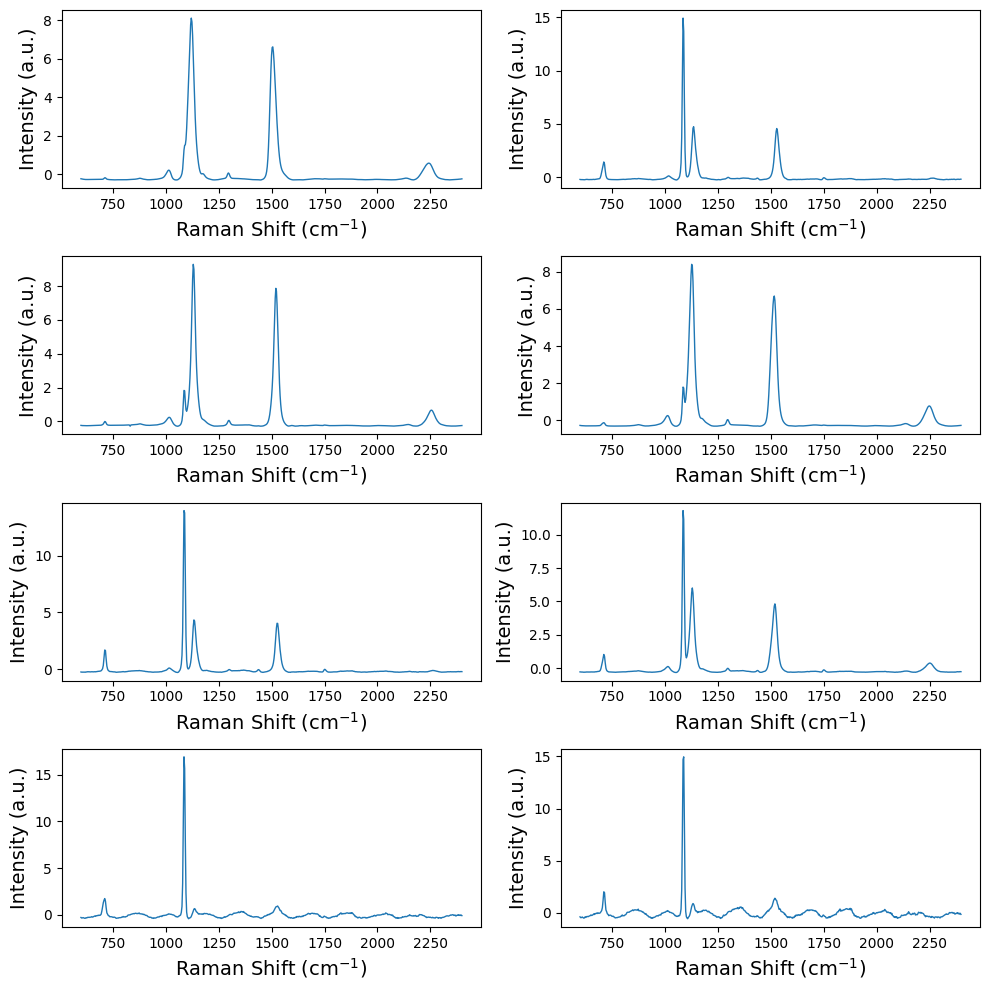

In [5]:
def avg_spectrum_all_paper(data,  muestras):
    #data = pd.concat(dataframes, axis=0)
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))
    # Itera sobre las muestras y representa cada una en su subplot
    for i, muestra in enumerate(muestras):
        data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
        wavenumber = data_muestra.columns.get_level_values(0).astype(float)
        # Calcula las intensidades medias para cada número de onda
        mean_intensity = data_muestra.mean(axis=0)


        # Calcula la posición del subplot en la matriz de subplots
        fila = i // 2
        columna = i % 2

        # Representa el espectro medio en el subplot correspondiente
        axes[fila, columna].plot(wavenumber, mean_intensity, label=f'Muestra {muestra}', lw=1)
        axes[fila, columna].set_xlabel('Raman Shift (cm$^{-1}$)',fontsize=14)
        axes[fila, columna].set_ylabel('Intensity (a.u.)',fontsize=14)
        #axes[fila, columna].grid(True, alpha=0.5)



    # Ajusta el espaciado entre subplots
    plt.tight_layout()
    


    # Muestra los subplots
    plt.show()

def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

data_sonda_2024_Matlab_snv = SNV(data_sonda_2024_Matlab)
data_sonda_2024_Python_snv = SNV(data_sonda_2024_Python)
data_sonda_2023_Matlab_snv = SNV(data_sonda_2023_Matlab)
data_nanobase_snv = SNV(data_nanobase)

def cut_spectrum(df, min_wavelength, max_wavelength):
    """
    Cuts the spectrum to a specific range.
    Parameters:
    - df (pandas.DataFrame): DataFrame containing the spectrum.
    - min_wavelength (int): Minimum wavelength.
    - max_wavelength (int): Maximum wavelength.
    Returns:
    - df_cut (pandas.DataFrame): DataFrame containing the spectrum within the specified range.
    """
    df.columns = df.columns.astype(float) #si tus columnas deben ser números flotantes
    df_cut = df.loc[:, (df.columns >= min_wavelength) & (df.columns <= max_wavelength)]
    return df_cut
df_cut_snv = cut_spectrum(data_sonda_2024_Matlab_snv, min_wavelength=600, max_wavelength=2400)
df_cut = cut_spectrum(data_sonda_2024_Matlab, min_wavelength=600, max_wavelength=2400)
avg_spectrum_all_paper(df_cut_snv, muestras_ordenadas)

## Elección del número de clusters.
Para la elección del número de clusters utilizamos el método del codo

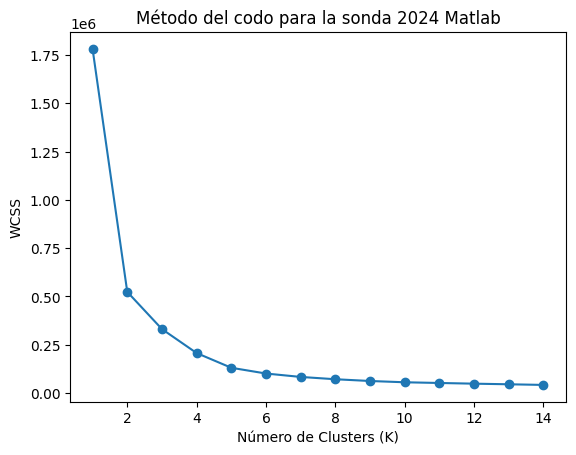

In [6]:
from scipy.cluster.hierarchy import linkage
def elbow_method (data, k_values, titulo):
     wcss = [] # Suma de los cuadrados de la distancia
     
     for k in k_values:
                model = KMeans(n_clusters=k)
                model.fit(data)
                wcss.append(model.inertia_)
                # La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide 
                # de su cluster asignado y sumando estos 
                # valores para todos los clusters. 
                # Esencialmente, mide la dispersión dentro de cada cluster.

    
    # Graficar el método del codo
     plt.plot(k_values, wcss, marker='o')
     plt.xlabel('Número de Clusters (K)')
     plt.ylabel('WCSS')
     plt.title(titulo)

warnings.filterwarnings("ignore")

# Definimos los valores de k a probar
k_values = range(1, 15) # Valores de k a probar

# Aplicamos el método del codo a los datos de la sonda 2024 Matlab
elbow_method(df_cut_snv, k_values, 'Método del codo para la sonda 2024 Matlab')

In [20]:
def clustering_K_Means(data, n_clusters):
    """
    Realiza clustering K-Means sobre el dataset proporcionado.
    :parameter *data*: matriz de datos, en formato: "channels(f) x time(c)".
    :parameter *n_clusters*: número de clusters a utilizar.
    :return: modelo de clustering K-Means entrenado.
    """
    t1 = time.time()
    kmeans = KMeans(n_clusters = n_clusters, random_state = 50).fit(data)
    data["Cluster_KMeans"] = kmeans.labels_
    # Convertir la columna Cluster_KMeans en un MultiIndex
    multiindex = pd.MultiIndex.from_frame(data[['Cluster_KMeans']])
    # Añadir el nuevo nivel de índice al multiíndice existente
    data = data.set_index(multiindex, append=True)
    data = data.drop(columns=['Cluster_KMeans'])
    t2 = time.time()
    tiempo = t2 - t1
    return data, tiempo

data = data_sonda_2023_Matlab_snv.copy()
n_clusters = 5 # Número de clusters a utilizar
data_kmeans, tiempo_kmeans = clustering_K_Means(data, n_clusters)
print(f"Tiempo de ejecución del clustering K-Means: {tiempo_kmeans:.2f} segundos")

Tiempo de ejecución del clustering K-Means: 10.89 segundos


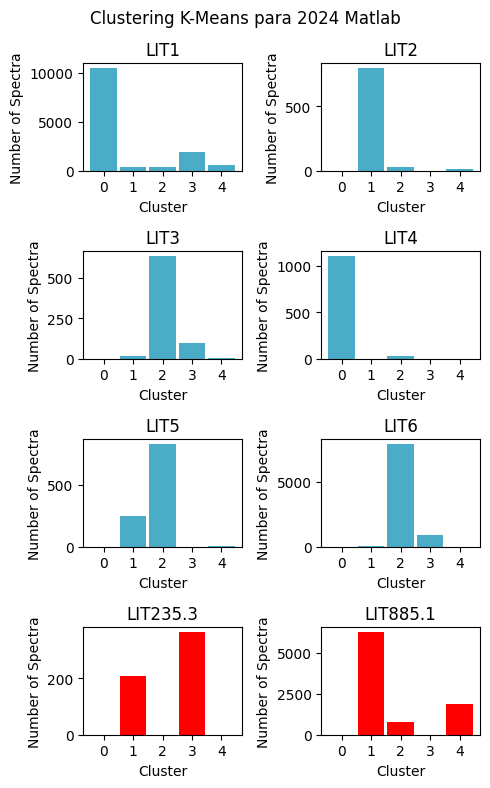

In [21]:
def plot_clusters_class_8muestras_2col(data, muestras, tipo_cluster='Cluster_KMeans', title= 'Distribución de los Clústers en las 8 muestras', color_tipo = '#1f77b4'):

    # Crear subplots con el diseño deseado
    fig, axes = plt.subplots(4, 2, figsize=(5, 8))


    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    indices_cluster = np.arange(len(todos_clusters))

    # Realizamos para cada muestra
    for i, muestra in enumerate(muestras):
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]

        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)
        color_actual = 'red' if muestra in [ 'LIT235.3', 'LIT885.1'] else color_tipo
        # Creamos un barplot
        row = i // 2
        col = i % 2
        axes[row, col].bar(indices_cluster, cluster_counts, width=0.9, label=tipo_cluster, color = color_actual)
        
        # Editamos el título para cada muestra
        axes[row, col].set_title(f"{muestra}")
        axes[row, col].set_xticks(indices_cluster)
        axes[row, col].set_xticklabels(todos_clusters)
        axes[row, col].set_xlabel("Cluster")
        axes[row, col].set_ylabel("Number of Spectra")


    # Añado un título general
    fig.suptitle(title)

    # Ajustar espaciado entre subplots
    plt.tight_layout()
    plt.show()

muestras_ordenadas = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3','LIT885.1']

plot_clusters_class_8muestras_2col(data_kmeans, muestras_ordenadas,'Cluster_KMeans', title = "Clustering K-Means para 2024 Matlab", color_tipo = "#4AACC6" )


In [22]:
def calculo_correlacion(data, muestras, tipo_cluster):
    frecuencias = []
    todos_clusters = sorted(data.index.get_level_values(tipo_cluster).unique().tolist())

    # Realizamos para cada muestra
    for muestra in muestras:
        # Separamos los espectros de la muestra
        data_muestra = data[data.index.get_level_values("Muestra") == muestra]
        # Contamos el número de veces de espectros correspondientes al clúster
        cluster_counts = data_muestra.index.get_level_values(tipo_cluster).value_counts().reindex(todos_clusters, fill_value=0)
        frecuencias.append(cluster_counts)

    # Calcular la media de cada vector
    medias = [np.mean(frec) for frec in frecuencias]

    # Calcular la matriz de correlación
    matriz_correlacion = np.corrcoef(frecuencias)

    # Crear una tabla para almacenar las correlaciones de Pearson
    correlaciones = []

    for i, muestra in enumerate(muestras[:-2]):
        correlacion_8 = np.corrcoef(frecuencias[i], frecuencias[-1])[0, 1]
        correlacion_7 = np.corrcoef(frecuencias[i], frecuencias[-2])[0, 1]
        correlaciones.append([muestra, correlacion_7, correlacion_8])

    # Convertir la lista de correlaciones en un DataFrame de pandas
    df_correlaciones = pd.DataFrame(correlaciones, columns=["Muestra", "Correlación con Muestra 7", "Correlación con Muestra 8"])

    # Encontrar la correlación más alta con las muestras 7 y 8
    max_correlacion_7 = df_correlaciones["Correlación con Muestra 7"].max()
    muestra_max_corr_7 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 7"].idxmax(), "Muestra"]
    
    max_correlacion_8 = df_correlaciones["Correlación con Muestra 8"].max()
    muestra_max_corr_8 = df_correlaciones.loc[df_correlaciones["Correlación con Muestra 8"].idxmax(), "Muestra"]

    # Imprimir las correlaciones más altas
    print(f"La correlación más alta con la Muestra 7 es {max_correlacion_7:.2f}, con la Muestra: {muestra_max_corr_7}")
    print(f"La correlación más alta con la Muestra 8 es {max_correlacion_8:.2f}, con la Muestra: {muestra_max_corr_8}")

    return matriz_correlacion, df_correlaciones

In [26]:
data_kmeans

178.6  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  1               1.545162   
                                                         72.434 9.042  1               1.544158   
                                                         72.484 9.042  1               1.515373   
                                                         72.534 9.042  1               1.595242   
                                                         72.584 9.042  1               1.513747   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.022581   
                                                         97.994 10.842 2               0.089754   
                                                         98.019 10.842 2               0.086251   
                                                         98.044 10.842 2              -0.177890   
                                                         98.069 10.842 2              -0.256411   

                                                                                         182.29  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  1               1.377188   
                                                         72.434 9.042  1               1.277396   
                                                         72.484 9.042  1               0.886986   
                                                         72.534 9.042  1               1.542916   
                                                         72.584 9.042  1               1.378429   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.146602   
                                                         97.994 10.842 2              -0.011632   
                                                         98.019 10.842 2              -0.289999   
                                                         98.044 10.842 2              -0.087000   
                                                         98.069 10.842 2              -0.173191   

                                                                                         185.98  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc 2023  0    arq235_preproc   72.384 9.042  1               0.821419   
                                                         72.434 9.042  1               1.022911   
                                                         72.484 9.042  1               0.806260   
                                                         72.534 9.042  1               1.177893   
                                                         72.584 9.042  1               1.170115   
...                                                                                         ...   
            LIT6     preproc 2023  0    moderna6_preproc 97.969 10.842 2              -0.176196   
                                                         97.994 10.842 2               0.048932   
                                                         98.019 10.842 2              -0.214786   
                                                         98.044 10.842 2              -0.271550   
                                                         98.069 10.842 2              -0.330868   

                                                                                         189.67  \
Instrumento Muestra  Tipo    Fecha Hora Archivo          X      Y      Cluster_KMeans             
Sonda 523nm LIT235.3 preproc

In [27]:
print("Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab")
data = data_kmeans.copy()
muestras = ['LIT1', 'LIT2', 'LIT3', 'LIT4', 'LIT5', 'LIT6', 'LIT235.3', 'LIT885.1']
matriz_correlacion, df_correlaciones_2023_Matlab_KMeans = calculo_correlacion(data, muestras, tipo_cluster="Cluster_KMeans")
print(df_correlaciones_2023_Matlab_KMeans)

Correlaciones entre las muestras y las muestras 7 y 8 para el dataset de 2023 Matlab
La correlación más alta con la Muestra 7 es 0.30, con la Muestra: LIT2
La correlación más alta con la Muestra 8 es 0.96, con la Muestra: LIT2
  Muestra  Correlación con Muestra 7  Correlación con Muestra 8
0    LIT1                  -0.270826                  -0.451141
1    LIT2                   0.300200                   0.961355
2    LIT3                  -0.255673                  -0.254504
3    LIT4                  -0.397468                  -0.389214
4    LIT5                  -0.302028                   0.075661
5    LIT6                  -0.294806                  -0.254945
